In [1]:
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, NASNetMobile, ResNet50V2, EfficientNetB0, DenseNet121
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input, MaxPool2D
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
TRAINING_DIR = "baru//Training"
VALIDATION_DIR = "baru//validation"

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    class_mode='categorical',
                                                    target_size=(224, 224))

validation_datagen = ImageDataGenerator(
    rescale=1.0/255
)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              class_mode='categorical',
                                                              target_size=(224, 224))


Found 4254 images belonging to 5 classes.
Found 964 images belonging to 5 classes.


In [5]:
print(train_generator.class_indices)

{'BercakHitam': 0, 'BukanDaunAnggur': 1, 'DaunSehat': 2, 'HawarDaun': 3, 'KaratDaun': 4}


In [6]:
# Pretrain Model
pre_trained_model = DenseNet121(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

for layer in pre_trained_model.layers:
    layer.trainable = False

model = tf.keras.Sequential([
    pre_trained_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

29084464/29084464 [==============================] - 11s 0us/step


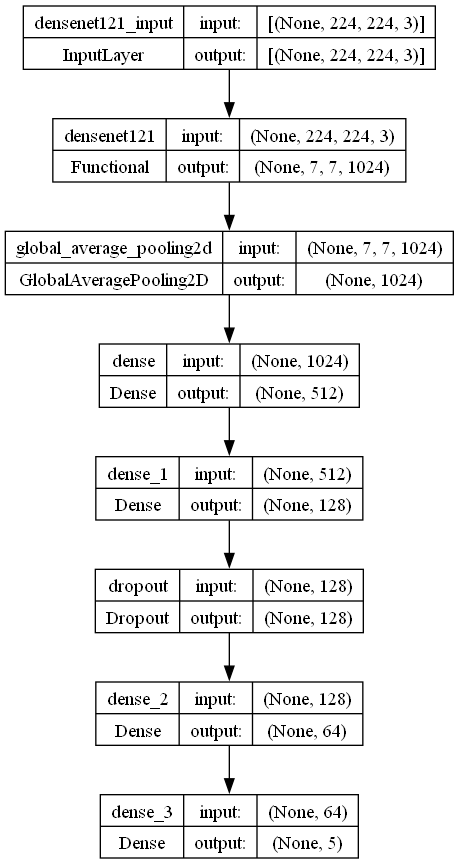

In [7]:
from tensorflow.keras.utils import plot_model

# visualisasi model
plot_model(model, to_file='modeldesnet.png', show_shapes=True)

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                        

In [10]:
int_lr = 0.0001
num_epochs = 100

# Early Stopping
earlystop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Model Checkpoint
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_weightsDesnet.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)
# Compile and Training
optimizer = tf.optimizers.Adam(learning_rate=int_lr)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(
    train_generator,
    epochs=num_epochs,
    validation_data=validation_generator,
    callbacks=[earlystop_callback, checkpoint_callback]
)

Epoch 1/100
133/133 [==============================] - ETA: 0s - loss: 0.9359 - accuracy: 0.6312
Epoch 1: val_accuracy improved from -inf to 0.83195, saving model to best_weightsDesnet.h5
133/133 [==============================] - 376s 3s/step - loss: 0.9359 - accuracy: 0.6312 - val_loss: 0.5260 - val_accuracy: 0.8320
Epoch 2/100
133/133 [==============================] - ETA: 0s - loss: 0.5349 - accuracy: 0.7875
Epoch 2: val_accuracy did not improve from 0.83195
133/133 [==============================] - 417s 3s/step - loss: 0.5349 - accuracy: 0.7875 - val_loss: 0.4479 - val_accuracy: 0.8091
Epoch 3/100
133/133 [==============================] - ETA: 0s - loss: 0.4356 - accuracy: 0.8237
Epoch 3: val_accuracy improved from 0.83195 to 0.86929, saving model to best_weightsDesnet.h5
133/133 [==============================] - 445s 3s/step - loss: 0.4356 - accuracy: 0.8237 - val_loss: 0.3497 - val_accuracy: 0.8693
Epoch 4/100
133/133 [==============================] - ETA: 0s - loss: 0.3589

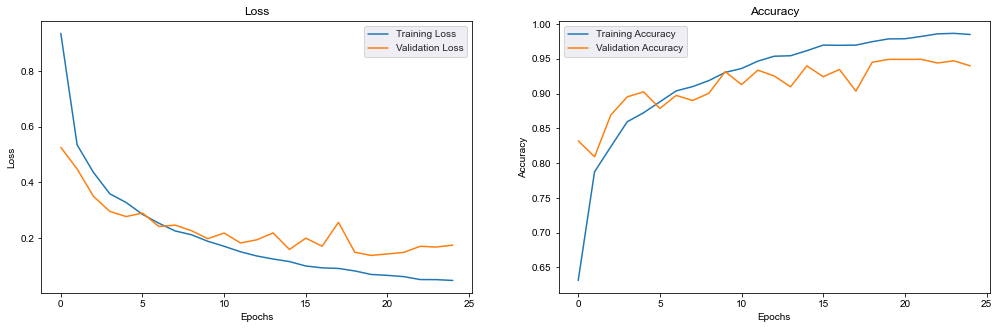

In [11]:
# Membuat list nilai loss dan akurasi dari model
train_loss = model.history.history['loss']
val_loss = model.history.history['val_loss']
train_acc = model.history.history['accuracy']
val_acc = model.history.history['val_accuracy']

# Membuat plot
fig, ax = plt.subplots(1, 2, figsize=(17, 5))
sns.set_style("darkgrid")

# Plot loss
ax[0].plot(train_loss, label='Training Loss')
ax[0].plot(val_loss, label='Validation Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss')
ax[0].legend()

# Plot accuracy
ax[1].plot(train_acc, label='Training Accuracy')
ax[1].plot(val_acc, label='Validation Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Accuracy')
ax[1].legend()

plt.show()

In [16]:
# Load weights
model.load_weights('best_weightsDesnet.h5')

# Evaluate model on validation set
loss, accuracy = model.evaluate(validation_generator, verbose=1)
print('Validation Accuracy: {:.2%}'.format(accuracy))
print('Validation Loss: {:.2f}'.format(loss))

31/31 [==============================] - 58s 2s/step - loss: 0.1371 - accuracy: 0.9492
Validation Accuracy: 94.92%
Validation Loss: 0.14


In [17]:
# Mendapatkan label yang sesuai dengan prediksi
class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}

In [18]:
# Memuat bobot terbaik yang disimpan selama pelatihan
model.load_weights('best_weightsDesnet.h5')

# Mengumpulkan semua prediksi dan label asli
y_pred = []
labels = []
for i in range(len(validation_generator)):
    batch_data, batch_labels = validation_generator[i]
    batch_pred = model.predict(batch_data)
    y_pred.extend(np.argmax(batch_pred, axis=1))
    labels.extend(np.argmax(batch_labels, axis=1))

1/1 [==============================] - 2s 2s/step


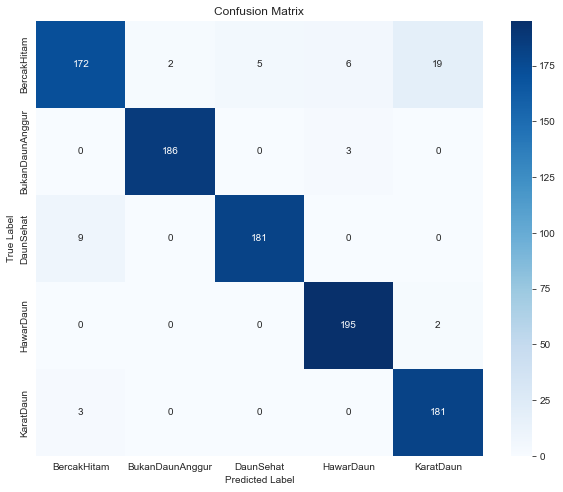

Classification Report:
                 precision    recall  f1-score   support

    BercakHitam       0.93      0.84      0.89       204
BukanDaunAnggur       0.99      0.98      0.99       189
      DaunSehat       0.97      0.95      0.96       190
      HawarDaun       0.96      0.99      0.97       197
      KaratDaun       0.90      0.98      0.94       184

       accuracy                           0.95       964
      macro avg       0.95      0.95      0.95       964
   weighted avg       0.95      0.95      0.95       964



In [19]:
# Menghitung matriks kebingungan
cm = confusion_matrix(labels, y_pred)

# Menghitung akurasi
accuracy = np.sum(labels == y_pred) / len(labels)

# Membuat plot matriks kebingungan
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels.values(), yticklabels=class_labels.values())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Mencetak laporan klasifikasi
classification_report_str = classification_report(labels, y_pred, target_names=class_labels.values())
print("Classification Report:")
print(classification_report_str)

In [20]:
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)

# Convert SavedModel menjadi .tflite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('densenet.tflite')
tflite_model_file.write_bytes(tflite_model)

INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


30297840